In [8]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn

In [9]:
# Connect to database
conn = sqlite3.connect("../../../databases/MLB_Betting.db")

In [10]:

# join query to get the season from each game as well 
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""

df = pd.read_sql_query(join_query, conn)
# Convert features_json column from string to dict
df["features_json"] = df["features_json"].apply(json.loads)
# Expand the dict into new DataFrame columns
features_df = pd.json_normalize(df["features_json"])

# Concatenate with the game_id
df_final = pd.concat([df["game_id"], df["season"], features_df], axis=1)
df_final["season"] = df_final["season"].astype(int)


In [11]:
df_final.isnull().sum().sum()

np.int64(0)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Train from 2015 to 2022
df_train = df_final[df_final["season"] <= 2022]

# Test on 2023 and 2024
df_test = df_final[df_final["season"] >= 2023]

# Target variable
Y_train = df_train["label"]
Y_test = df_test["label"]

# features
X_train = df_train.drop(columns=["game_id", "home_team_id", "away_team_id", "season", "label"])
X_test = df_test.drop(columns=["game_id", "home_team_id", "away_team_id", "season", "label"])

# Metadata (for tracking predictions later)
game_ids_train = df_train["game_id"]
game_ids_test = df_test["game_id"]

home_team_train = df_train["home_team_id"]
home_team_test = df_test["home_team_id"]

away_team_train = df_train["away_team_id"]
away_team_test = df_test["away_team_id"]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

Accuracy: 0.5581
Precision: 0.5622
Recall: 0.7099
F1 Score: 0.6275

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.39      0.46      2237
           1       0.56      0.71      0.63      2465

    accuracy                           0.56      4702
   macro avg       0.56      0.55      0.54      4702
weighted avg       0.56      0.56      0.55      4702

ROC AUC Score: 0.5789


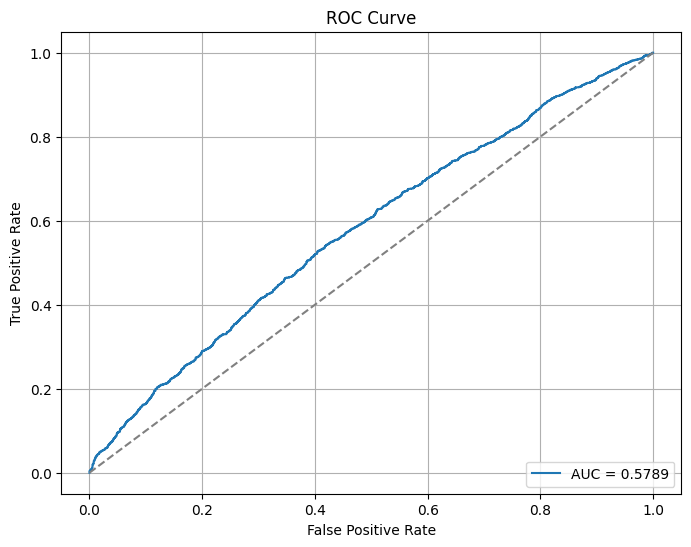

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42) 
# Train the model
logreg.fit(X_train_scaled, Y_train)


# Predict on test set
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
